In [30]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19, nasnet, resnet_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [32]:
# dataset load
# X_train.shape = (50000, 32, 32, 3)
# x_test.shape = (10000, 32, 32, 3)
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)


# dataset preprocessing
img_rows, img_cols, _ = x_train.shape[1:]   # (H, W, C)

X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
num_classes = 10
batch_size = 16


# model design
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))
conv_base.trainable = False
print(model.summary())



# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# model seleiction setting
filepath = 'weights/best_model01-{epoch:02d}-{val_accuracy:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)

# learning rate scheduler
lrr= ReduceLROnPlateau(
                       monitor='val_loss', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate

# model complie setting
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.009)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# training
hist = model.fit(X_train, Y_train,
                 epochs=10000,
                 batch_size=16,
                 validation_split=0.2,
                 callbacks=[es, mc, lrr])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/10000
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4257 - accurac

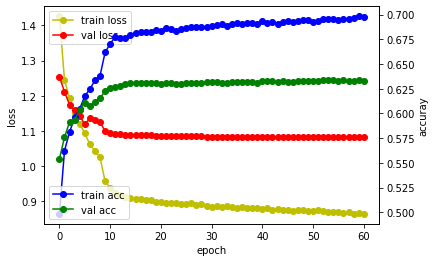

In [33]:
# train curve

%matplotlib inline

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss', marker='o')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss', marker='o')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc', marker='o')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc', marker='o')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [35]:
# filename = ''
# best_model = load_model(os.path.join('weights', filename))

scores = model.evaluate(X_test, Y_test, batch_size=16)
print("%s: %.3f" %(model.metrics_names[0], scores[0]))
print("%s: %.3f" %(model.metrics_names[1], scores[1]))

625/625 [==============================] - 2s 4ms/step - loss: 1.0903 - accuracy: 0.6235
loss: 1.090
accuracy: 0.623
